## Preparing the dataset

We split the dataset into training, validation and test datasets.

The input should be a csv file, as it can be downloaded from WRDS

## Import libraries and datasets

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt

In [2]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

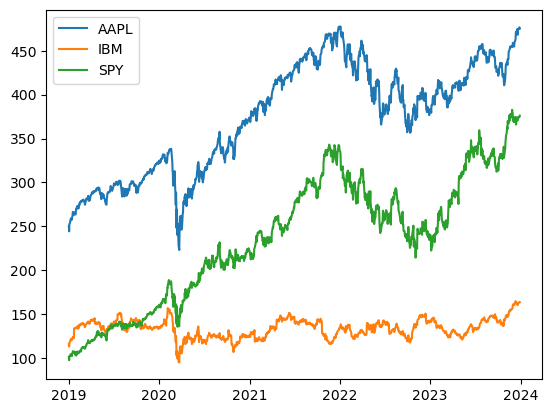

In [3]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

## Creating training, validation and testing dataset

- For each ticker, we create a dataset of the form $\{(x_t,y_t)\}_{t=n,...,N}$, where $x_t$ is the vector containing all prices between time $t-n$ and time $t$, and $y_t$ is the vector containing prices at time $t+1$.

- We will experiment with predicting a time series based on its previous prices for the last $n$ days

- If we want to include more predicting variables, such as daily high and low and volumes, they can just be added in the definition of `ts`

In [4]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

In [5]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}
for name, data in tickers:
    data = data[['PRC']].diff().dropna()
    ts[name] = data.values#.flatten()
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0]*0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0]*0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

In [6]:
print(X_train['SPY'][0])
print(X_train['SPY'][1])
print(y_train['SPY'][0])

[-3.72  4.53  0.13  0.74  1.47 -0.67 -0.8  -0.75  2.96  0.37]
[ 4.53  0.13  0.74  1.47 -0.67 -0.8  -0.75  2.96  0.37  0.74]
[0.74]


## Example for linear regression

In [7]:
from sklearn.linear_model import LinearRegression

y_pred = {}
model = LinearRegression()
model.fit(X_train['SPY'], y_train['SPY'].ravel())
y_pred['SPY'] = model.predict(X_test['SPY'])

In [8]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test['SPY'], y_pred['SPY']))

4.790779008966088

Alternatively, we can simply train a seingle neuron of neural network, without activation function

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # remove warnings
import tensorflow as tf

In [10]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [11]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[10]),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")

c:\Users\yoshi\anaconda3\envs\AI_Predictions\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train['SPY'], y_train['SPY'], epochs=400,
                validation_data=(X_valid['SPY'], y_valid['SPY']),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
100,13.802282,34.072323
101,13.802230,34.071220
102,13.802185,34.070255
103,13.802153,34.069405
104,13.802125,34.068661
105,13.802103,34.068012
106,13.802090,34.067448
107,13.802081,34.066967
108,13.802077,34.066559
109,13.802077,34.066216


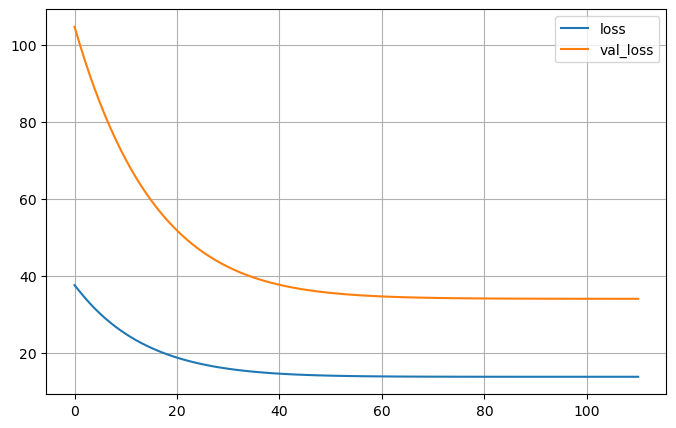

In [13]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The RMSE should be similar to the one obtained performing linear regression

In [15]:
ypred = model.predict(X_test['SPY'])
np.sqrt(mean_squared_error(y_test['SPY'], ypred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


4.795917173620563